In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import collections
import matplotlib.pyplot as plt
import random

import warnings
warnings.filterwarnings(action='ignore')

random.seed(2023)


In [3]:
# 데이터 불러오기
df = pd.read_csv('penguins_size.csv')

## 데이터 정보 확인

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


- species : 펭귄 종
- island : 샘플이 수집된 지점 근처 섬 이름
- culmen_length_mm : 펭귄 옆모습 기준 **부리의 가로 길이**
- culmen_depth_mm : 펭귄 옆모습 기준 **부리의 세로 길이**
- flipper_length_mm : 펭귄의 **팔(날개) 길이**
- body_mass_g : 펭귄의 **몸무게**
- sex : 성별

## 결측치 확인 및 이상지 탐지

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64


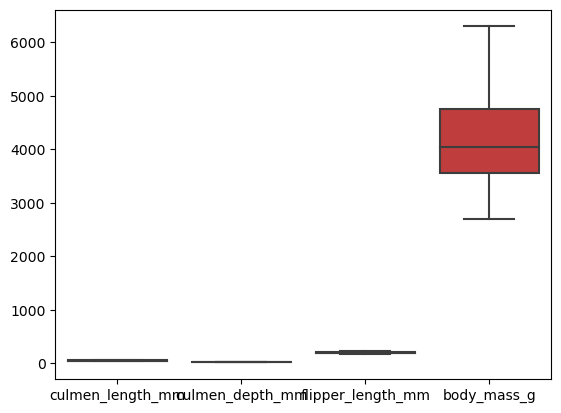

In [4]:
# 결측치 확인
print(df.isnull().sum())

# 이상치 탐지
sns.boxplot(data=df)
plt.show()

In [23]:
# 결측치 제거
df = df.dropna()
df

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,FEMALE
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


결측치의 수가 적어 제거해도 무방할 것이라 예상하여 제거하였음

## 데이터 별 특성 분포
각 변수를 x축, y축으로 두어 종별 데이터 분포 확인

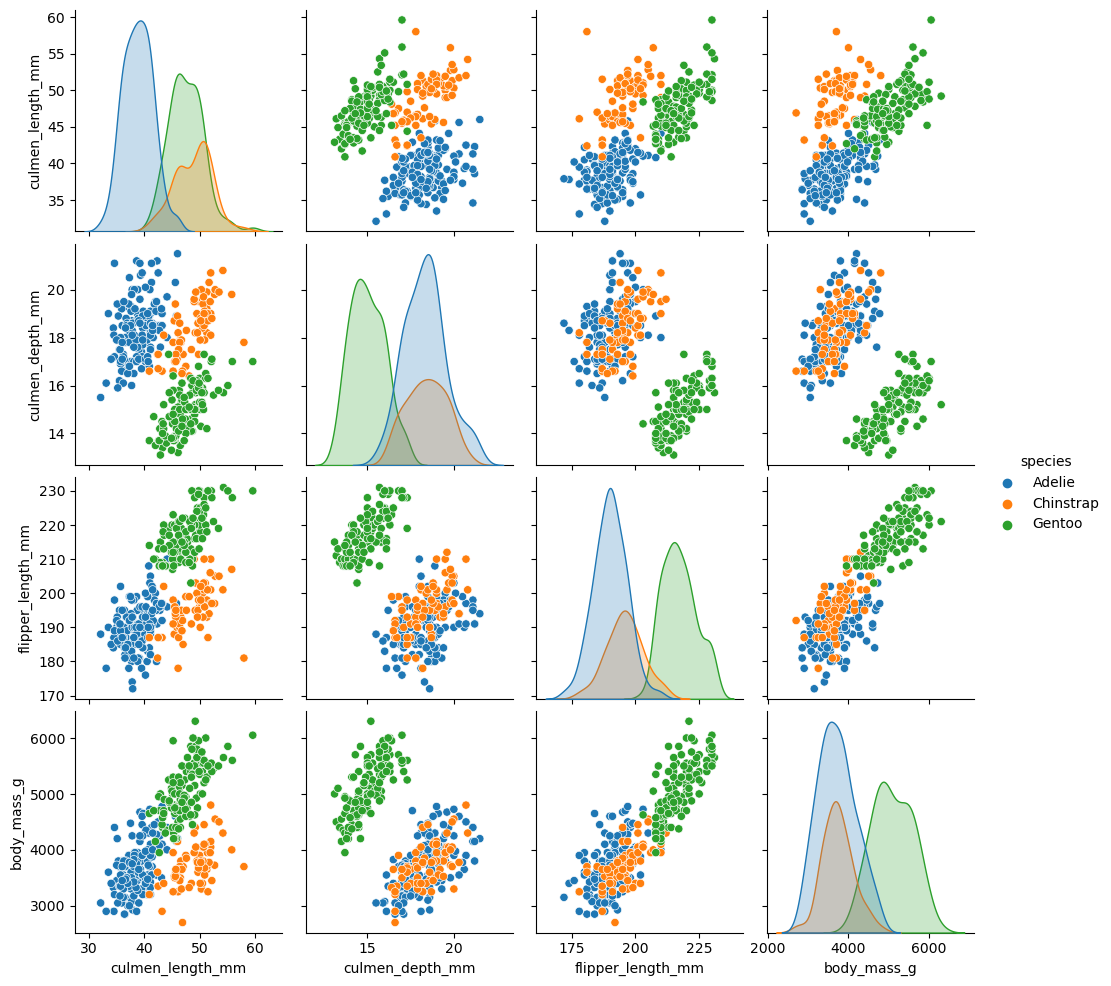

In [15]:
# 특성 분포 확인
sns.pairplot(df, hue='species')
plt.show()

부리의 가로 길이, 세로 길이 중 한 가지가 축이 되었을 때 종별로 가장 잘 나누어졌음

## 종별 데이터 수 히스토그램
- 종별로 데이터 수의 차이를 확인하고자 히스토그램 작성

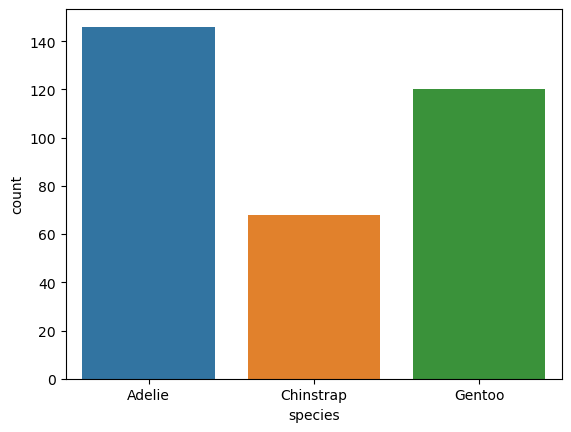

In [16]:
sns.countplot(data=df, x='species')
plt.show()

Adelie > Gentoo > Chinstrap 순으로 데이터 수에 차이가 있음을 확인

## 라벨 인코딩
- 카테고리형(오브젝트형)인 경우 인코딩 진행
- 카테고리 수가 많지 않아 인코딩 방식이 크게 영향을 주지 않을 것으로 예상되어 라벨 인코딩을 선택

In [24]:
from sklearn.preprocessing import LabelEncoder

# 데이터프레임에서 object 형태인 열 선택
object_columns = df.select_dtypes(include=['object']).columns

# 라벨 인코더 생성 및 적용
label_encoder = LabelEncoder()
for col in object_columns:
    df[col] = label_encoder.fit_transform(df[col])

df

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,39.1,18.7,181.0,3750.0,2
1,0,2,39.5,17.4,186.0,3800.0,1
2,0,2,40.3,18.0,195.0,3250.0,1
4,0,2,36.7,19.3,193.0,3450.0,1
5,0,2,39.3,20.6,190.0,3650.0,2
...,...,...,...,...,...,...,...
338,2,0,47.2,13.7,214.0,4925.0,1
340,2,0,46.8,14.3,215.0,4850.0,1
341,2,0,50.4,15.7,222.0,5750.0,2
342,2,0,45.2,14.8,212.0,5200.0,1


'species', 'island', 'sex' 변수가 인코딩 되었음

## 상관행렬 분석
- 타겟과 상관관계가 높은 변수일 수록 해당 데이터를 잘 설명하는 변수라고 할 수 있음
- 변수 별로 상관 계수를 계산하여 상관 행렬을 시각화

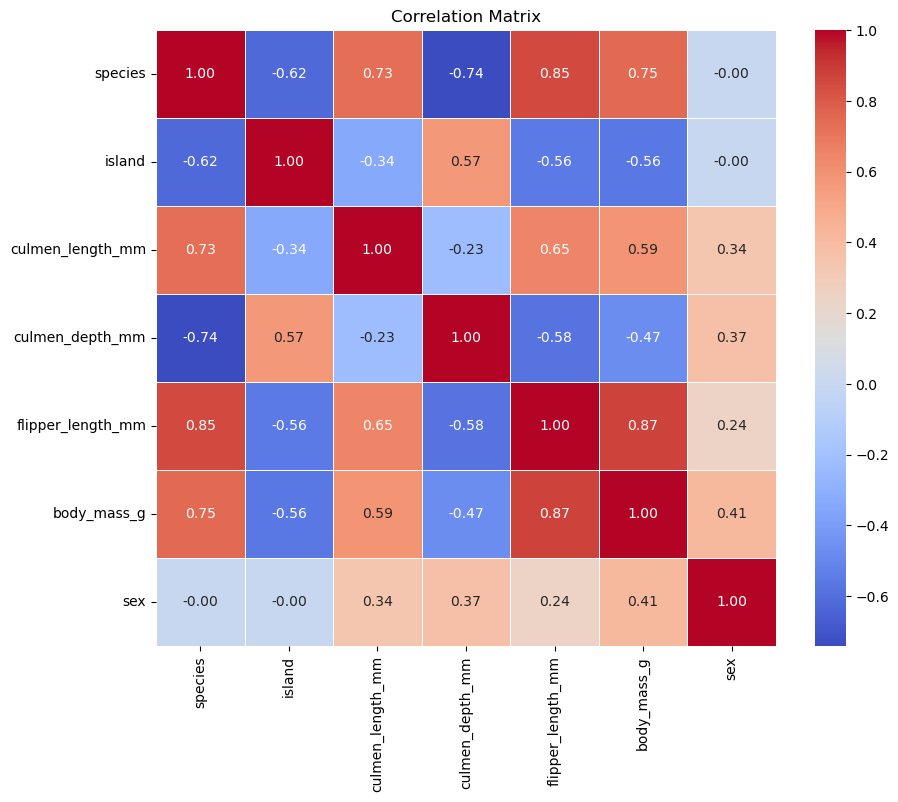

In [25]:
# 상관 행렬 계산
correlation_matrix = df.corr()

# 상관 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


- 날개 길이, 몸무게, 부리의 세로 길이, 부리의 가로 길이 순으로 펭귄 종과 상관관계가 컸음
- 이외에 몸무게와 날개의 길이 간의 상관 관계가 높게 나타남